In [1]:
from fastai.data.all import *
from fastai.tabular.all import *
from fastai.vision.all import *
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))

from enveco.tabular.preprocessing import *
from enveco.model.ensemble import *
from enveco.interpretation import *
from enveco.metrics import *

/home/mayrajeo/miniconda3/envs/enveco/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# Compare results

In [2]:
result_path = Path('results_15_1/')
folders = os.listdir(result_path)
data_path = Path('../../enveco_data/enveco/')


d_results = [f for f in folders if f.startswith('d_')]
g_results = [f for f in folders if f.startswith('g_')]
h_results = [f for f in folders if f.startswith('h_')]
v_ma_results = [f for f in folders if f.startswith('v_ma_')]
v_ku_results = [f for f in folders if f.startswith('v_ku_')]
v_lp_results = [f for f in folders if f.startswith('v_lp_')]
v_results = [f for f in folders if f.startswith('v_') and 
             not any([f.startswith('v_ma_'), f.startswith('v_ku_'), f.startswith('v_lp_')])]

In [3]:
preprocessor = EnvecoPreprocessor(data_path/'AV.leaf.on.train.csv',
                                  data_path/'AV.leaf.on.val.csv',
                                  data_path/'AV.leaf.on.test.csv')

def get_test_tbs(preprocessor, target):
    _, test_las = preprocessor.load_las(path='model_data', target_col=target, log_y=False)
    _, test_image = preprocessor.load_image(path='model_data', target_col=target, log_y=False)
    _, test_both = preprocessor.load_las_image(path='model_data', target_col=target, log_y=False)
    _, test_las_log = preprocessor.load_las(path='model_data', target_col=target, log_y=True)
    _, test_image_log = preprocessor.load_image(path='model_data', target_col=target, log_y=True)
    _, test_both_log = preprocessor.load_las_image(path='model_data', target_col=target, log_y=True)
    return (test_las.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False), 
            test_image.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False), 
            test_both.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False), 
            test_las_log.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False), 
            test_image_log.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False), 
            test_both_log.dataloaders(y_block=RegressionBlock(), shuffle_train=False, drop_last=False))

In [4]:
def get_models(path, folders):
    both = load_ensemble(path/folders[0]/'models')
    both_log = load_ensemble(path/folders[1]/'models')
    image = load_ensemble(path/folders[2]/'models')
    image_log = load_ensemble(path/folders[3]/'models')
    las = load_ensemble(path/folders[4]/'models')
    las_log = load_ensemble(path/folders[5]/'models')
    return both, both_log, image, image_log, las, las_log

In [5]:
import matplotlib.patches as mpl_patches
def plot_regression_results(preds:pd.Series, y:TabularPandas, log_y:bool=False, **kwargs) -> plt.Axes:
    "Similar plotting utility than RegressionInterpretation for scikit-learn models"
    if len(preds.shape) != 2: preds = preds[:,None]
    y = y.values
    if len(y.shape) != 2: y = y[:,None]
    if log_y: 
        preds = np.expm1(preds)
        y = np.expm1(y)
    n_targs = 1
    axs = get_grid(n_targs, figsize=((6+1)*n_targs, (6)*n_targs)) # if we have multitarget
    for i, a in enumerate(axs):
        im = a.scatter(y[:,i], preds[:,i], c=np.abs(y[:,i]-preds[:,i]))
        a.set_xlabel('Real value')
        a.set_ylabel('Predicted value')
        a.grid()
        x = np.linspace(0, max(preds[:,i].max(),y[:,i].max()))
        a.plot(x, x, color='orange')
        m, b = np.polyfit(y[:,i], preds[:,i], 1)
        a.plot(x, m*x+b, color='blue')
        cbar = plt.colorbar(im, ax=a)
        cbar.ax.set_ylabel('Deviations', rotation=90)
        res_mae = mae(Tensor(y[:,i]), Tensor(preds[:,i]))
        res_mse = mse(Tensor(y[:,i]), Tensor(preds[:,i]))
        res_rmse = rmse(Tensor(y[:,i]), Tensor(preds[:,i]))
        res_rrmse = res_rmse / y.mean() * 100
        r2 = R2Score()(Tensor(y[:,i]), Tensor(preds[:,i]))
        res_bias = bias(Tensor(y[:,i]), Tensor(preds[:,i]))
        res_pct_bias = bias_pct(Tensor(y[:,i]), Tensor(preds[:,i]))
        handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                   lw=0, alpha=0)] * 8
        labels = [f'MSE: {res_mse:.2f}', f'RMSE: {res_rmse:.2f}', f'RRMSE: {res_rrmse:.2f}%',
                  f'MAE: {res_mae:.2f}', f'R2: {r2:.2f}',
                  f'BIAS: {res_bias:.2f}', f'BIAS-%: {res_pct_bias:.2f}%']
        a.legend(handles, labels, loc='best', fancybox=True, handlelength=0, handletextpad=0)
    return axs

In [6]:
knn_results = pd.read_csv(result_path/'knn_res_test.csv', delimiter=';', header=1)
cols = knn_results.columns

In [7]:
knn_results.rename(columns=lambda c: f'{c}_pred' if c != 'sampleplotid' else c, inplace=True)

In [8]:
test_df = preprocessor.test_df

In [9]:
knn_results = knn_results.merge(test_df[cols], on='sampleplotid')

In [13]:
knn_results['tot_pred_v'] = knn_results.v_ma_pred + knn_results.v_ku_pred + knn_results.v_lp_pred

In [15]:
knn_results.head(9)

v_pred     h_pred     d_pred   v_ma_pred   v_ku_pred  v_lp_pred  \
0  166.888345  12.124718  12.468071   15.523815   63.638903  68.172482   
1  326.668587  19.345315  23.541607   33.998256  208.199903  88.656798   
2  222.375120  17.940220  22.261659  190.233490   41.737128   9.289617   
3  329.468044  22.888759  29.596873  160.401914  221.931688  10.835941   
4  320.883470  23.641335  30.569313  120.093559  185.013473  38.963172   
5  106.162699  13.613510  17.157085   71.167130   17.366236  12.170113   
6   62.170071   8.432507  10.231046   34.990582   11.499375  13.963447   
7  190.736394  19.133200  26.530930  126.048509   67.254210  18.519598   
8  177.629052  17.826406  21.708809   53.342138  109.801703  40.456930   

   sampleplotid       v     h     d    v_ma    v_ku   v_lp  tot_pred_v  
0        901025  220.31  12.6  12.7    0.00  141.55  78.77  147.335199  
1        901037  295.26  18.6  19.2    0.00  202.92  92.34  330.854956  
2        901058  206.61  18.4  23.3  189.46   16.39   0.76  241.260235  
3        902066  374.58  25.4  29.0  163.94  193.44  17.21  393.169543  
4        902074  479.10  23.2  29.0  163.34  294.22  21.54  344.070203  
5        903028   85.78  12.0  14.0   64.66    0.87  20.25  100.703479  
6        903031   63.82   9.0  10.8   26.84   23.58  13.40   60.453404  
7        903054  154.77  18.3  24.5  115.11   33.32   6.34  211.822317  
8        903058  288.07  19.1  26.6    0.00  275.39  12.68  203.600771

<ipython-input-5-7614bd990842>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if len(preds.shape) != 2: preds = preds[:,None]


[<AxesSubplot:xlabel='Real value', ylabel='Predicted value'>]

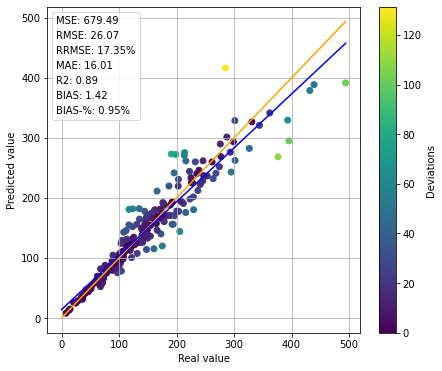

In [53]:
plot_regression_results(knn_results.v_pred, knn_results.tot_pred_v)

<ipython-input-5-7614bd990842>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if len(preds.shape) != 2: preds = preds[:,None]


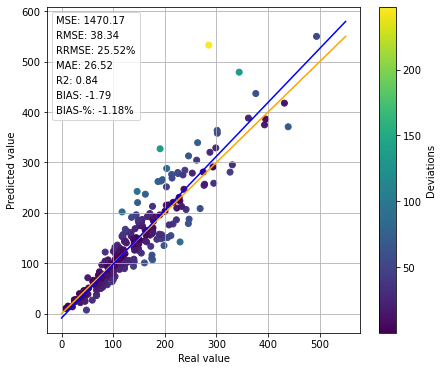

In [52]:
plot_regression_results(knn_results.v, knn_results.tot_pred_v)
plt.show()

<ipython-input-5-7614bd990842>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if len(preds.shape) != 2: preds = preds[:,None]


[<AxesSubplot:xlabel='Real value', ylabel='Predicted value'>]

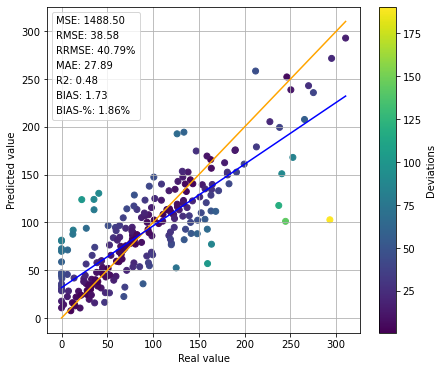

In [45]:
plot_regression_results(knn_results.v_pred * (knn_results.v_ma_pred / (knn_results.v_lp_pred + knn_results.v_ku_pred + knn_results.v_ma_pred)), 
                        knn_results.v_ma)

<ipython-input-5-7614bd990842>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if len(preds.shape) != 2: preds = preds[:,None]


[<AxesSubplot:xlabel='Real value', ylabel='Predicted value'>]

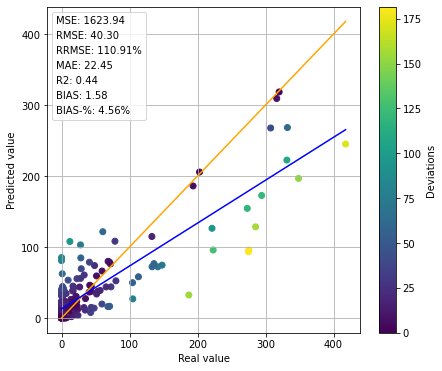

In [46]:
plot_regression_results(knn_results.v_pred * (knn_results.v_ku_pred / (knn_results.v_lp_pred + knn_results.v_ku_pred + knn_results.v_ma_pred)), 
                        knn_results.v_ku)

<ipython-input-5-7614bd990842>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if len(preds.shape) != 2: preds = preds[:,None]


[<AxesSubplot:xlabel='Real value', ylabel='Predicted value'>]

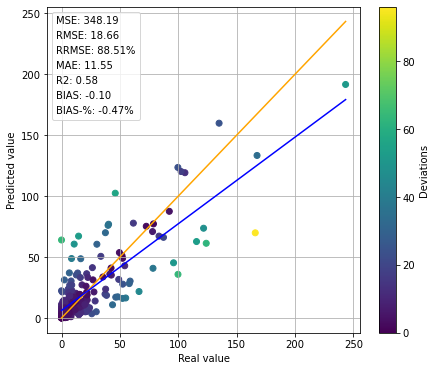

In [47]:
plot_regression_results(knn_results.v_pred * (knn_results.v_lp_pred / (knn_results.v_lp_pred + knn_results.v_ku_pred + knn_results.v_ma_pred)), 
                        knn_results.v_lp)

In [33]:
knn_results.v_pred.describe()

count    225.000000
mean     148.804082
std       79.133751
min        7.948974
25%       93.220811
50%      137.671241
75%      182.076927
max      416.445342
Name: v_pred, dtype: float64

In [32]:
knn_results.v.describe()

count    225.000000
mean     152.013644
std       97.223845
min        7.000000
25%       87.820000
50%      134.980000
75%      192.530000
max      550.170000
Name: v, dtype: float64

# Volume

In [32]:
target = 'v'
test_las, test_image, test_both, test_las_log, test_image_log, test_both_log = get_test_tbs(preprocessor, target)

In [33]:
both, both_log, image, image_log, las, las_log = get_models(result_path, v_results)

## Only LAS data

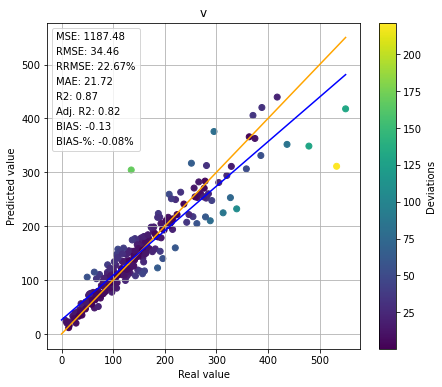

In [34]:
las_interp = RegressionInterpretation.from_ensemble(las, dl=test_las.train, ds_idx=0)
las_interp.plot_results(log_y=False)
plt.show()

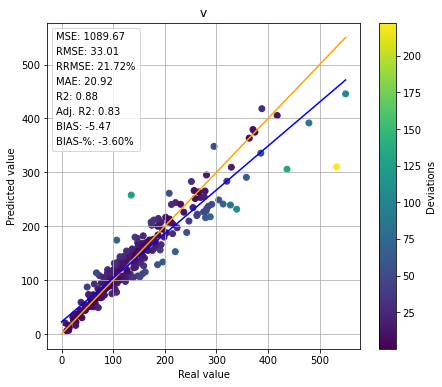

In [35]:
las_log_interp = RegressionInterpretation.from_ensemble(las_log, dl=test_las_log.train, ds_idx=0)
las_log_interp.plot_results(log_y=True)
plt.show()

## Only image data

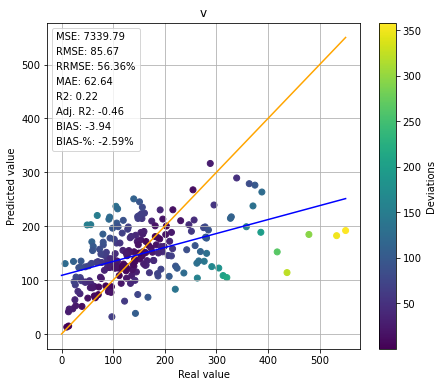

In [36]:
image_interp = RegressionInterpretation.from_ensemble(image, dl=test_image.train, ds_idx=0)
image_interp.plot_results(log_y=False)
plt.show()

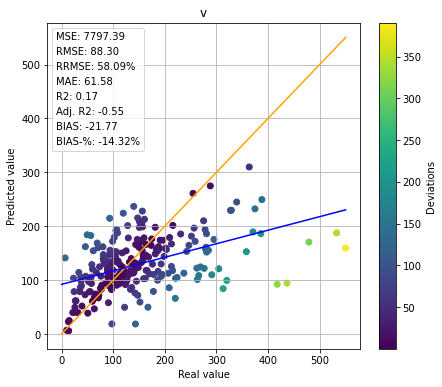

In [37]:
image_log_interp = RegressionInterpretation.from_ensemble(image_log, dl=test_image_log.train, ds_idx=0)
image_log_interp.plot_results(log_y=True)
plt.show()

## Both

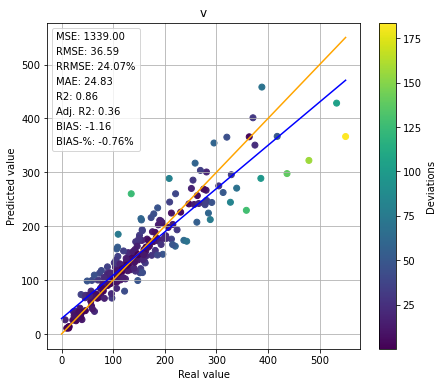

In [38]:
both_interp = RegressionInterpretation.from_ensemble(both, dl=test_both.train, ds_idx=0)
both_interp.plot_results(log_y=False)
plt.show()

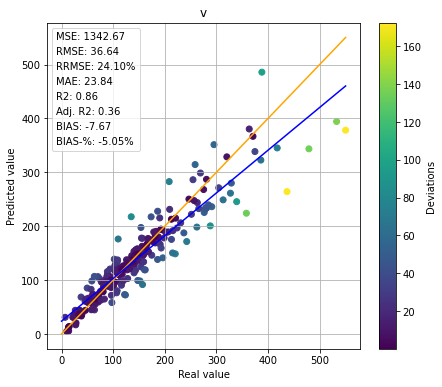

In [39]:
both_log_interp = RegressionInterpretation.from_ensemble(both_log, dl=test_both_log.train, ds_idx=0)
both_log_interp.plot_results(log_y=True)
plt.show()

## KNN

<ipython-input-53-7614bd990842>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if len(preds.shape) != 2: preds = preds[:,None]


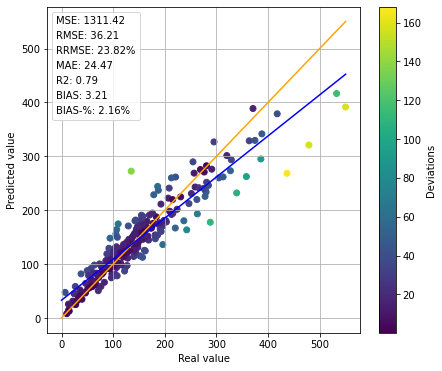

In [55]:
plot_regression_results(knn_results[f'{target}_pred'], knn_results[target])
plt.show()

# DBH

In [57]:
test_las, test_image, test_both, test_las_log, test_image_log, test_both_log = get_test_tbs(preprocessor, 'd')

In [58]:
both, both_log, image, image_log, las, las_log = get_models(result_path, d_results)

## Only LAS data

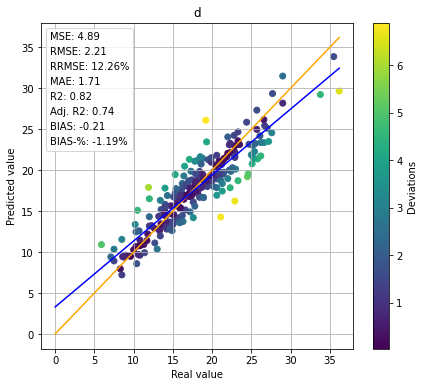

In [59]:
las_interp = RegressionInterpretation.from_ensemble(las, dl=test_las.train, ds_idx=0)
las_interp.plot_results(log_y=False)
plt.show()

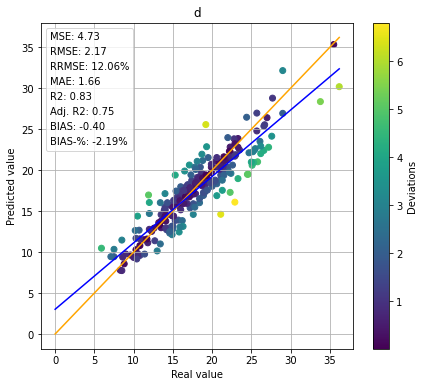

In [60]:
las_log_interp = RegressionInterpretation.from_ensemble(las_log, dl=test_las_log.train, ds_idx=0)
las_log_interp.plot_results(log_y=True)
plt.show()

## Only image data

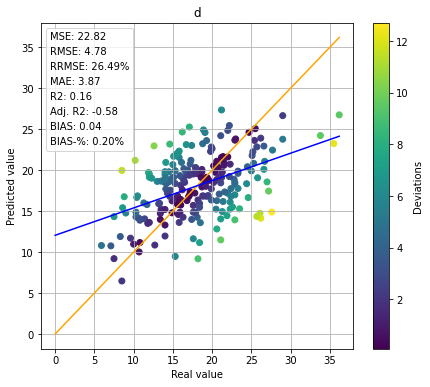

In [61]:
image_interp = RegressionInterpretation.from_ensemble(image, dl=test_image.train, ds_idx=0)
image_interp.plot_results(log_y=False)
plt.show()

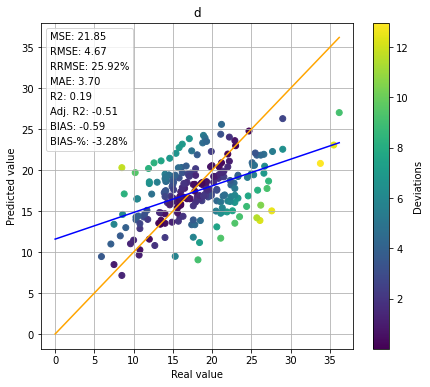

In [62]:
image_log_interp = RegressionInterpretation.from_ensemble(image_log, dl=test_image_log.train, ds_idx=0)
image_log_interp.plot_results(log_y=True)
plt.show()

## Both

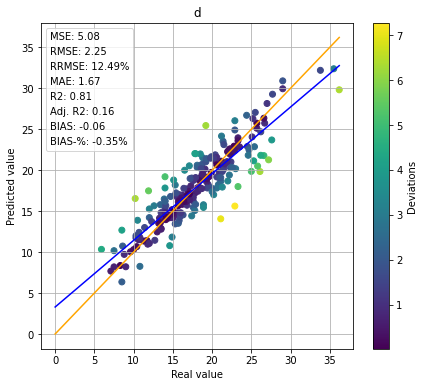

In [63]:
both_interp = RegressionInterpretation.from_ensemble(both, dl=test_both.train, ds_idx=0)
both_interp.plot_results(log_y=False)
plt.show()

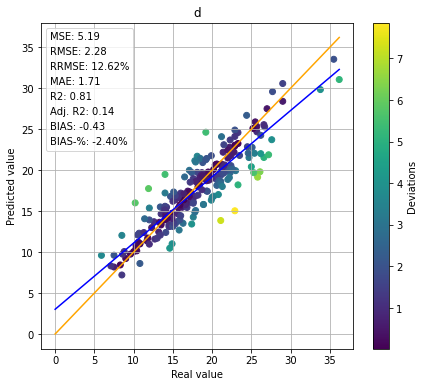

In [64]:
both_log_interp = RegressionInterpretation.from_ensemble(both_log, dl=test_both_log.train, ds_idx=0)
both_log_interp.plot_results(log_y=True)
plt.show()

## KNN

<ipython-input-53-7614bd990842>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if len(preds.shape) != 2: preds = preds[:,None]


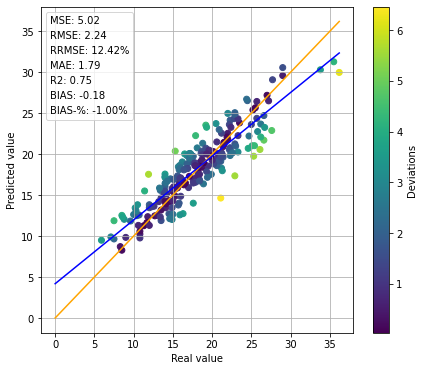

In [65]:
target = 'd'
plot_regression_results(knn_results[f'{target}_pred'], knn_results[target])
plt.show()

# Basal area

In [21]:
test_las, test_image, test_both, test_las_log, test_image_log, test_both_log = get_test_tbs(preprocessor, 'g')

In [22]:
both, both_log, image, image_log, las, las_log = get_models(result_path, g_results)

## Only LAS data

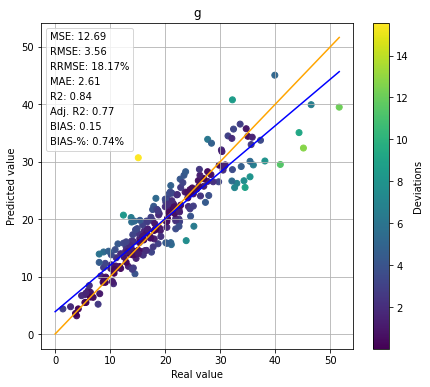

In [23]:
las_interp = RegressionInterpretation.from_ensemble(las, dl=test_las.train, ds_idx=0)
las_interp.plot_results(log_y=False)
plt.show()

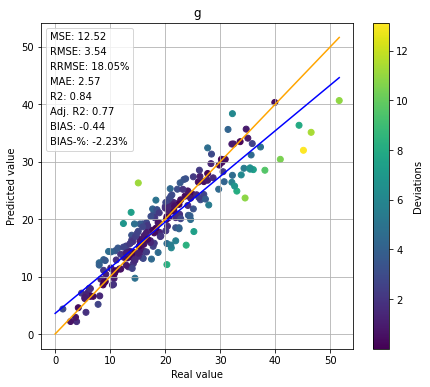

In [24]:
las_log_interp = RegressionInterpretation.from_ensemble(las_log, dl=test_las_log.train, ds_idx=0)
las_log_interp.plot_results(log_y=True)
plt.show()

## Only image data

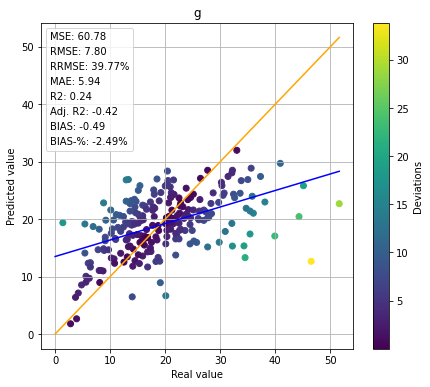

In [25]:
image_interp = RegressionInterpretation.from_ensemble(image, dl=test_image.train, ds_idx=0)
image_interp.plot_results(log_y=False)
plt.show()

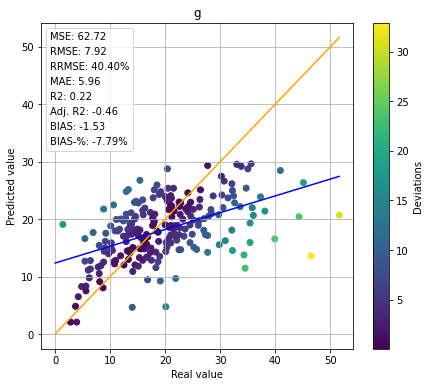

In [26]:
image_log_interp = RegressionInterpretation.from_ensemble(image_log, dl=test_image_log.train, ds_idx=0)
image_log_interp.plot_results(log_y=True)
plt.show()

## Both

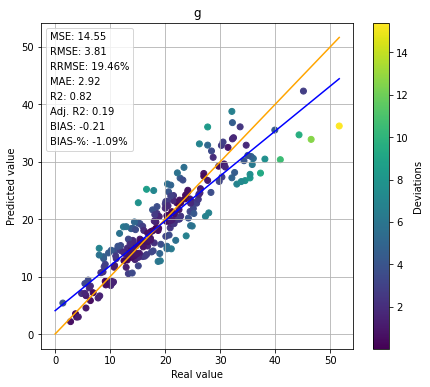

In [27]:
both_interp = RegressionInterpretation.from_ensemble(both, dl=test_both.train, ds_idx=0)
both_interp.plot_results(log_y=False)
plt.show()

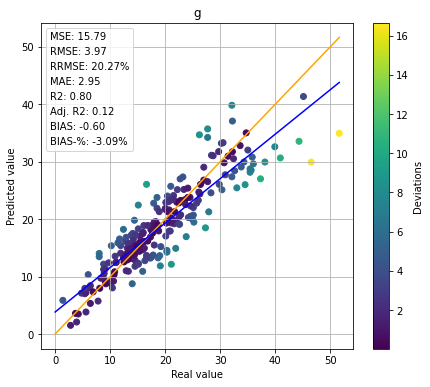

In [28]:
both_log_interp = RegressionInterpretation.from_ensemble(both_log, dl=test_both_log.train, ds_idx=0)
both_log_interp.plot_results(log_y=True)
plt.show()

# Height

In [66]:
test_las, test_image, test_both, test_las_log, test_image_log, test_both_log = get_test_tbs(preprocessor, 'h')

In [67]:
both, both_log, image, image_log, las, las_log = get_models(result_path, h_results)

## Only LAS data

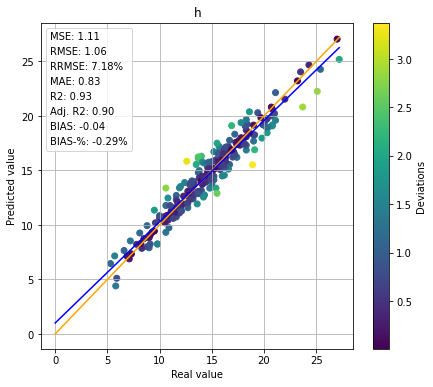

In [68]:
las_interp = RegressionInterpretation.from_ensemble(las, dl=test_las.train, ds_idx=0)
las_interp.plot_results(log_y=False)
plt.show()

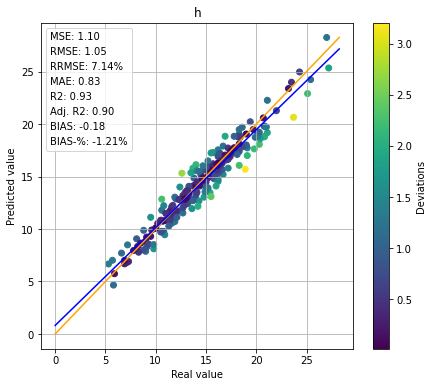

In [69]:
las_log_interp = RegressionInterpretation.from_ensemble(las_log, dl=test_las_log.train, ds_idx=0)
las_log_interp.plot_results(log_y=True)
plt.show()

## Only image data

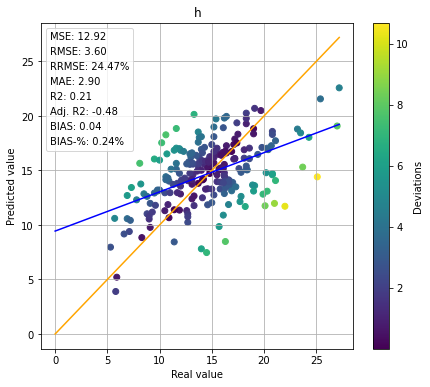

In [70]:
image_interp = RegressionInterpretation.from_ensemble(image, dl=test_image.train, ds_idx=0)
image_interp.plot_results(log_y=False)
plt.show()

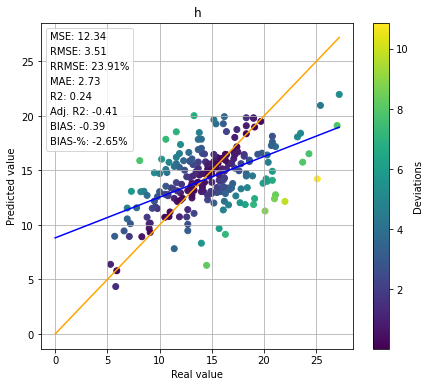

In [71]:
image_log_interp = RegressionInterpretation.from_ensemble(image_log, dl=test_image_log.train, ds_idx=0)
image_log_interp.plot_results(log_y=True)
plt.show()

## Both

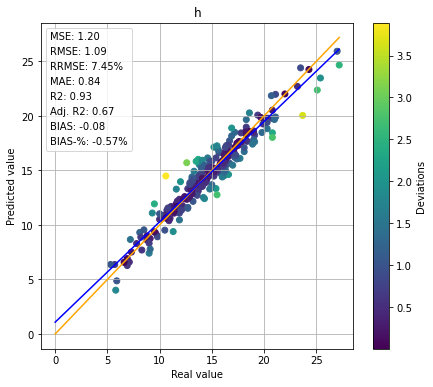

In [72]:
both_interp = RegressionInterpretation.from_ensemble(both, dl=test_both.train, ds_idx=0)
both_interp.plot_results(log_y=False)
plt.show()

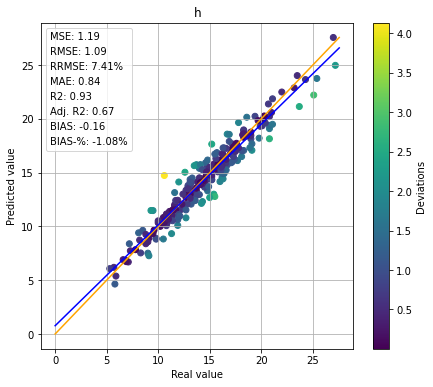

In [73]:
both_log_interp = RegressionInterpretation.from_ensemble(both_log, dl=test_both_log.train, ds_idx=0)
both_log_interp.plot_results(log_y=True)
plt.show()

## KNN

<ipython-input-53-7614bd990842>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if len(preds.shape) != 2: preds = preds[:,None]


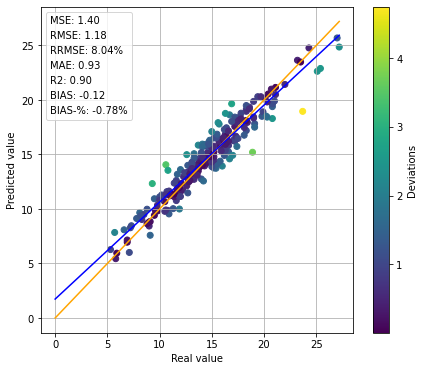

In [74]:
target = 'h'
plot_regression_results(knn_results[f'{target}_pred'], knn_results[target])
plt.show()

# Species-wise volumes

## Volume of pine

In [75]:
test_las, test_image, test_both, test_las_log, test_image_log, test_both_log = get_test_tbs(preprocessor, 'v_ma')

In [76]:
both, both_log, image, image_log, las, las_log = get_models(result_path, v_ma_results)

### Only LAS data

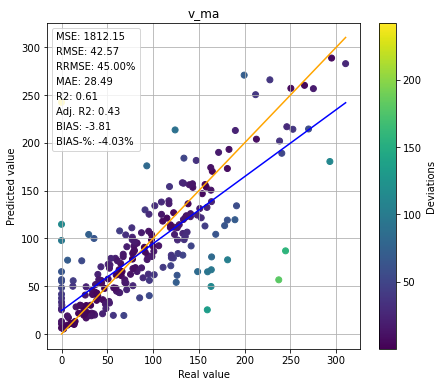

In [77]:
las_interp = RegressionInterpretation.from_ensemble(las, dl=test_las.train, ds_idx=0)
las_interp.plot_results(log_y=False)
plt.show()

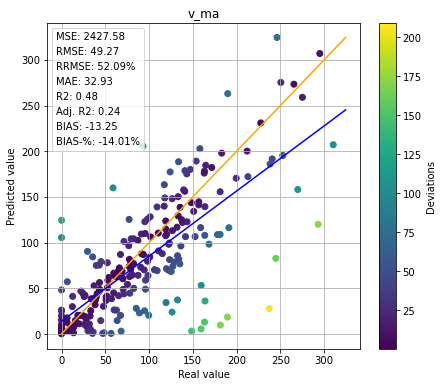

In [78]:
las_log_interp = RegressionInterpretation.from_ensemble(las_log, dl=test_las_log.train, ds_idx=0)
las_log_interp.plot_results(log_y=True)
plt.show()

### Only image data

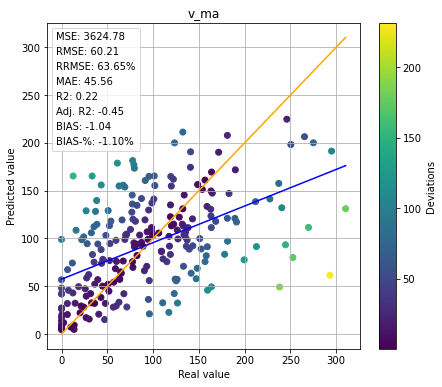

In [79]:
image_interp = RegressionInterpretation.from_ensemble(image, dl=test_image.train, ds_idx=0)
image_interp.plot_results(log_y=False)
plt.show()

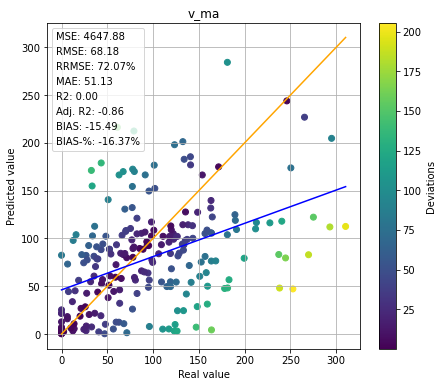

In [80]:
image_log_interp = RegressionInterpretation.from_ensemble(image_log, dl=test_image_log.train, ds_idx=0)
image_log_interp.plot_results(log_y=True)
plt.show()

### Both

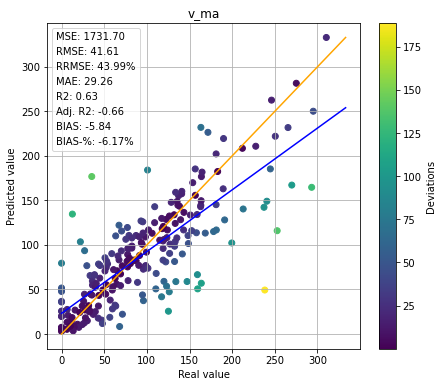

In [81]:
both_interp = RegressionInterpretation.from_ensemble(both, dl=test_both.train, ds_idx=0)
both_interp.plot_results(log_y=False)
plt.show()

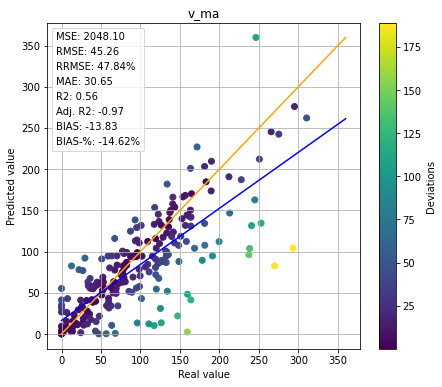

In [82]:
both_log_interp = RegressionInterpretation.from_ensemble(both_log, dl=test_both_log.train, ds_idx=0)
both_log_interp.plot_results(log_y=True)
plt.show()

### KNN

<ipython-input-53-7614bd990842>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if len(preds.shape) != 2: preds = preds[:,None]


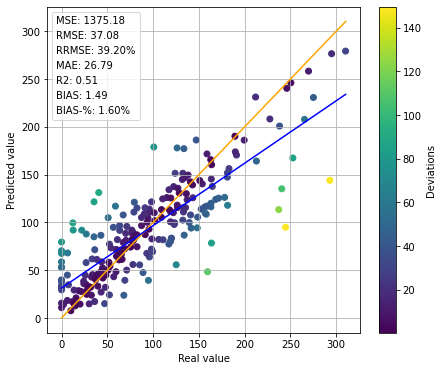

In [83]:
target = 'v_ma'
plot_regression_results(knn_results[f'{target}_pred'], knn_results[target])
plt.show()

## Volume of spruce

In [84]:
test_las, test_image, test_both, test_las_log, test_image_log, test_both_log = get_test_tbs(preprocessor, 'v_ku')

In [85]:
both, both_log, image, image_log, las, las_log = get_models(result_path, v_ku_results)

### Only LAS data

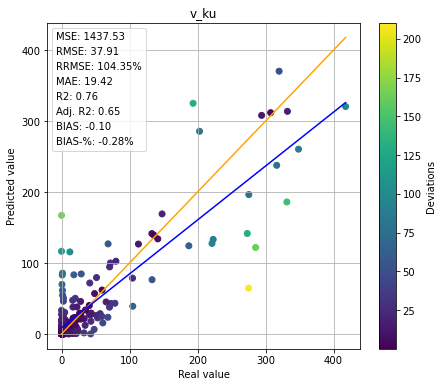

In [86]:
las_interp = RegressionInterpretation.from_ensemble(las, dl=test_las.train, ds_idx=0)
las_interp.plot_results(log_y=False)
plt.show()

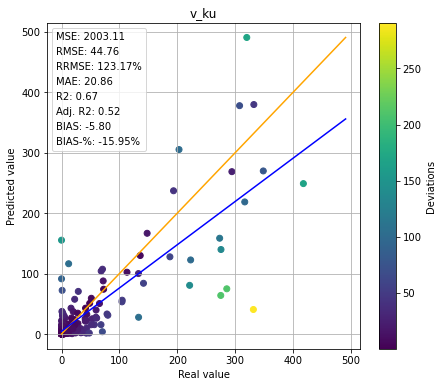

In [87]:
las_log_interp = RegressionInterpretation.from_ensemble(las_log, dl=test_las_log.train, ds_idx=0)
las_log_interp.plot_results(log_y=True)
plt.show()

### Only image data

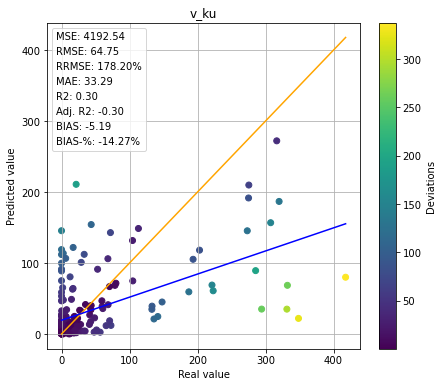

In [88]:
image_interp = RegressionInterpretation.from_ensemble(image, dl=test_image.train, ds_idx=0)
image_interp.plot_results(log_y=False)
plt.show()

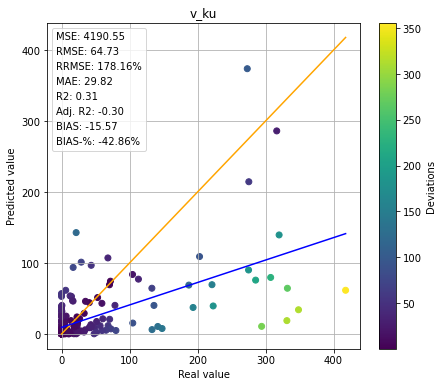

In [89]:
image_log_interp = RegressionInterpretation.from_ensemble(image_log, dl=test_image_log.train, ds_idx=0)
image_log_interp.plot_results(log_y=True)
plt.show()

### Both

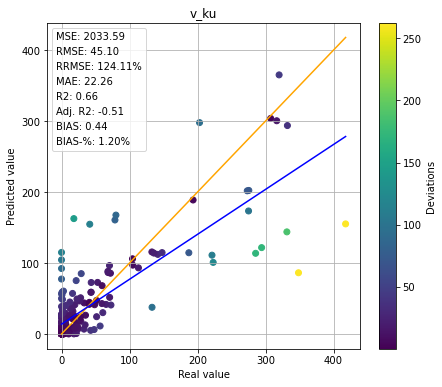

In [90]:
both_interp = RegressionInterpretation.from_ensemble(both, dl=test_both.train, ds_idx=0)
both_interp.plot_results(log_y=False)
plt.show()

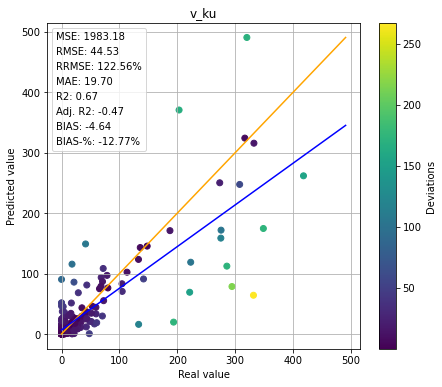

In [91]:
both_log_interp = RegressionInterpretation.from_ensemble(both_log, dl=test_both_log.train, ds_idx=0)
both_log_interp.plot_results(log_y=True)
plt.show()

### KNN

<ipython-input-53-7614bd990842>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if len(preds.shape) != 2: preds = preds[:,None]


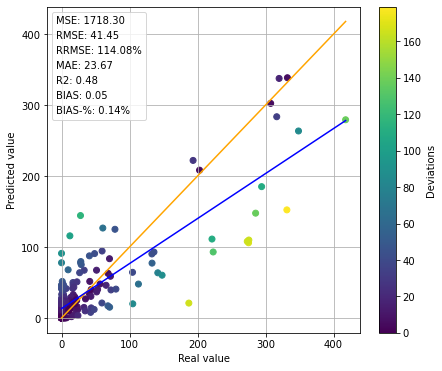

In [92]:
target = 'v_ku'
plot_regression_results(knn_results[f'{target}_pred'], knn_results[target])
plt.show()

## Volume of broadleafs

In [93]:
test_las, test_image, test_both, test_las_log, test_image_log, test_both_log = get_test_tbs(preprocessor, 'v_lp')

In [94]:
both, both_log, image, image_log, las, las_log = get_models(result_path, v_lp_results)

### Only LAS data

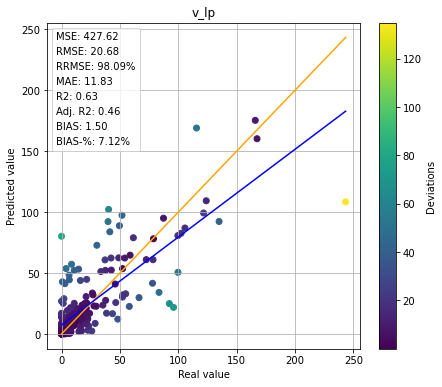

In [95]:
las_interp = RegressionInterpretation.from_ensemble(las, dl=test_las.train, ds_idx=0)
las_interp.plot_results(log_y=False)
plt.show()

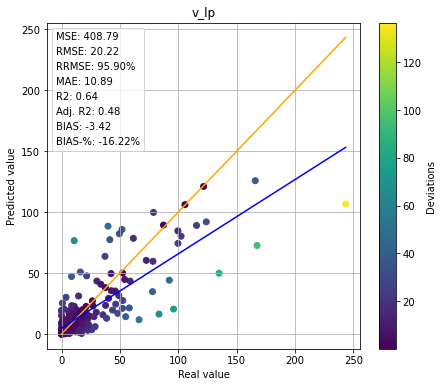

In [96]:
las_log_interp = RegressionInterpretation.from_ensemble(las_log, dl=test_las_log.train, ds_idx=0)
las_log_interp.plot_results(log_y=True)
plt.show()

### Only image data

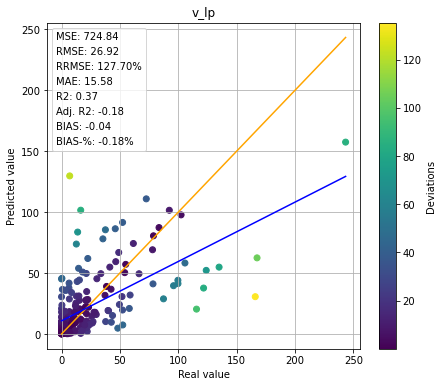

In [97]:
image_interp = RegressionInterpretation.from_ensemble(image, dl=test_image.train, ds_idx=0)
image_interp.plot_results(log_y=False)
plt.show()

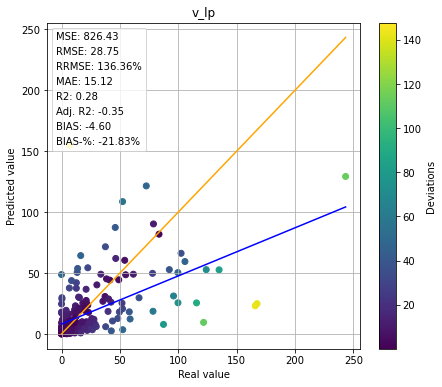

In [98]:
image_log_interp = RegressionInterpretation.from_ensemble(image_log, dl=test_image_log.train, ds_idx=0)
image_log_interp.plot_results(log_y=True)
plt.show()

### Both

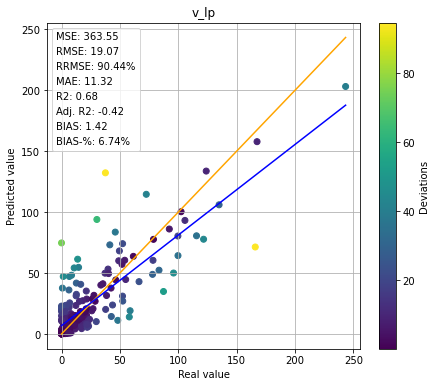

In [99]:
both_interp = RegressionInterpretation.from_ensemble(both, dl=test_both.train, ds_idx=0)
both_interp.plot_results(log_y=False)
plt.show()

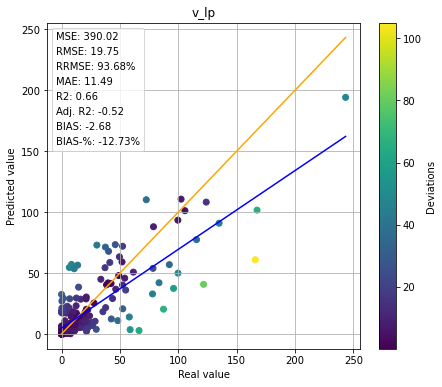

In [100]:
both_log_interp = RegressionInterpretation.from_ensemble(both_log, dl=test_both_log.train, ds_idx=0)
both_log_interp.plot_results(log_y=True)
plt.show()

### KNN

<ipython-input-53-7614bd990842>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if len(preds.shape) != 2: preds = preds[:,None]


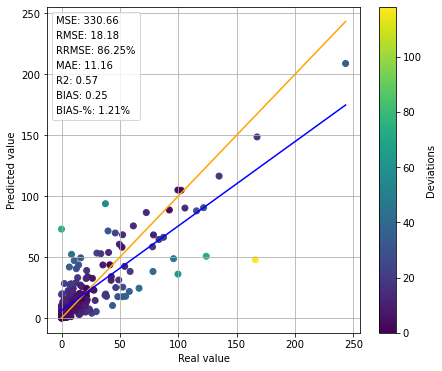

In [101]:
target = 'v_lp'
plot_regression_results(knn_results[f'{target}_pred'], knn_results[target])
plt.show()

# Volumes via proportions

In [ ]:
def get_species_volumes